# Short Report

## 1. Preprocessing Steps and Rationale

### Data Loading and Cleaning:
- Loaded the dataset from a CSV file.
- Dropped columns with all NaN values and rows with any NaN values to ensure data integrity.
- Converted all feature columns to numeric, handling non-numeric data by removing non-numeric characters.

### Feature Scaling:
- Applied MinMaxScaler to normalize features between 0 and 1, which helps in improving model convergence and performance.

## 2. Dimensionality Reduction

### PCA (Principal Component Analysis):
- Performed PCA to reduce dimensionality while retaining 95% of the variance.
- Visualized the explained variance to understand the contribution of each principal component.

### t-SNE (t-Distributed Stochastic Neighbor Embedding):
- Applied t-SNE for 2D visualization to explore the data's structure and potential clustering.

## 3. Model Selection, Training, and Evaluation

### Model Selection:
- Evaluated three models: Random Forest, XGBoost, and MLPRegressor.
- Used GridSearchCV for hyperparameter tuning to find the best model configuration.

### Training and Evaluation:
- Split the data into training and testing sets (80/20).
- Trained models using both original and PCA-reduced features.
- Evaluated models using MAE, RMSE, and R² metrics.

### Results:
- Random Forest with PCA-reduced features showed strong performance with lower error metrics compared to other models.
- Visualized actual vs. predicted values to assess model accuracy.

## 4. Key Findings and Suggestions for Improvement

### Findings:
- Dimensionality reduction via PCA helped in reducing model complexity without significant loss of information.
- Random Forest outperformed other models, likely due to its robustness and ability to handle non-linear relationships.

### Suggestions for Improvement:
- Explore additional feature engineering techniques to enhance model input.
- Consider advanced ensemble methods or stacking models for potentially better performance.
- Implement cross-validation for more robust performance evaluation.
- Investigate domain-specific data augmentation techniques to enrich the dataset.

# Below is the implemetation of the project.

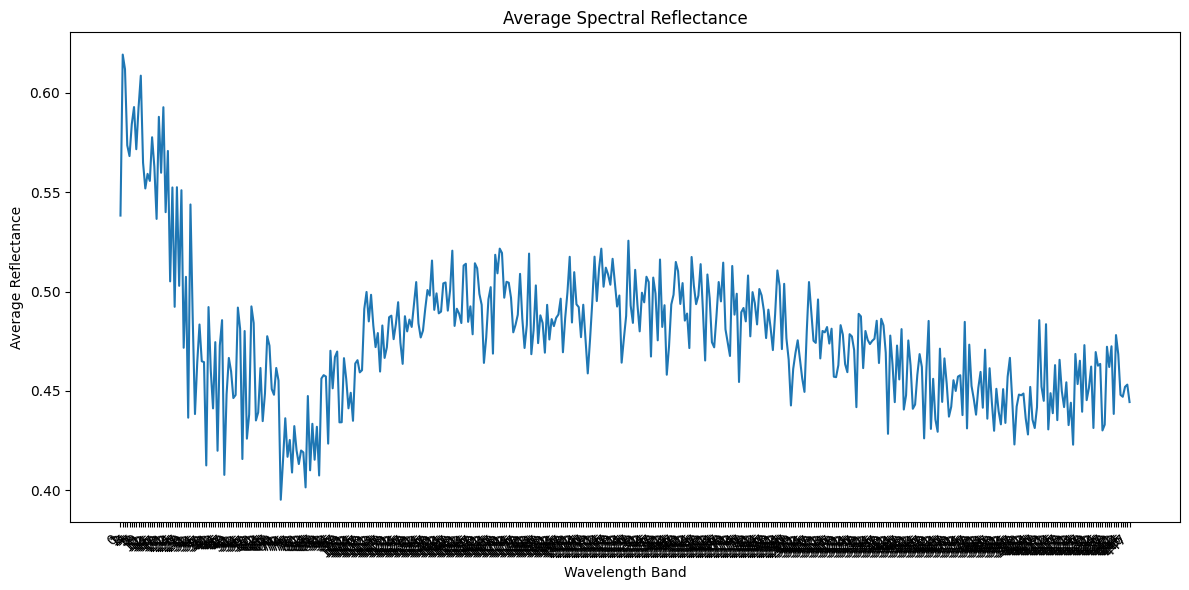

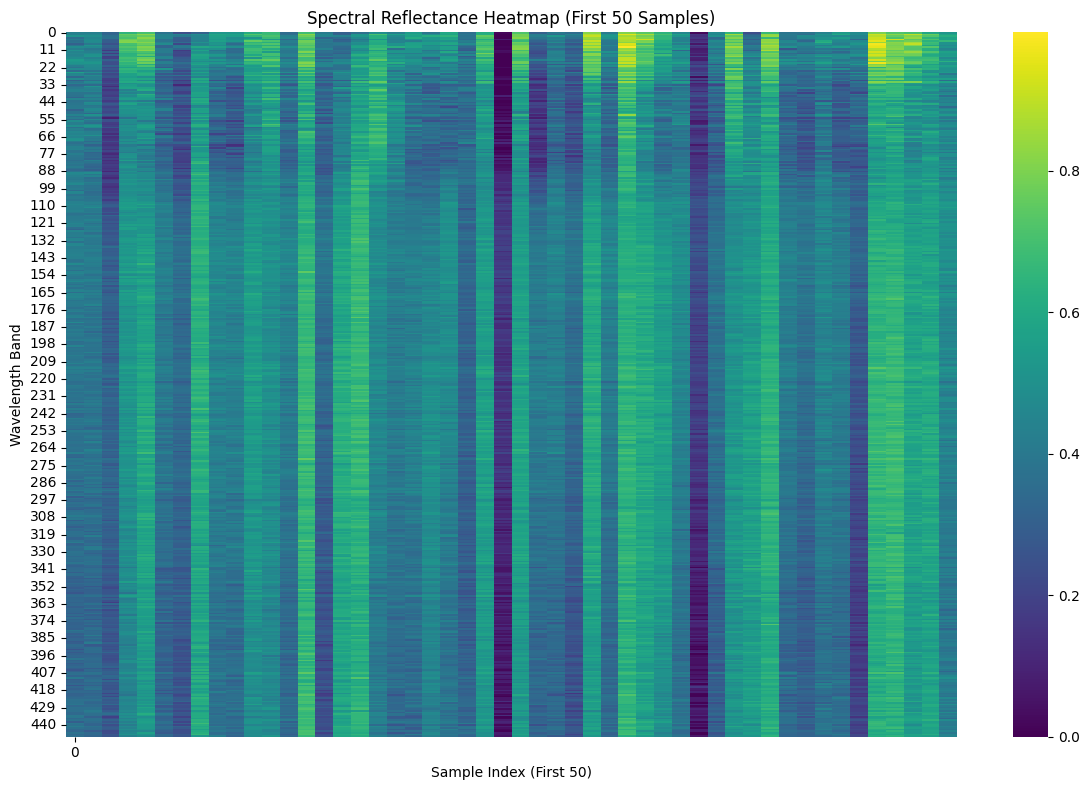

Explained Variance Ratio: [0.8582386  0.06683037 0.01916925 0.01566534]
Cumulative Explained Variance: [0.8582386  0.92506897 0.94423822 0.95990356]


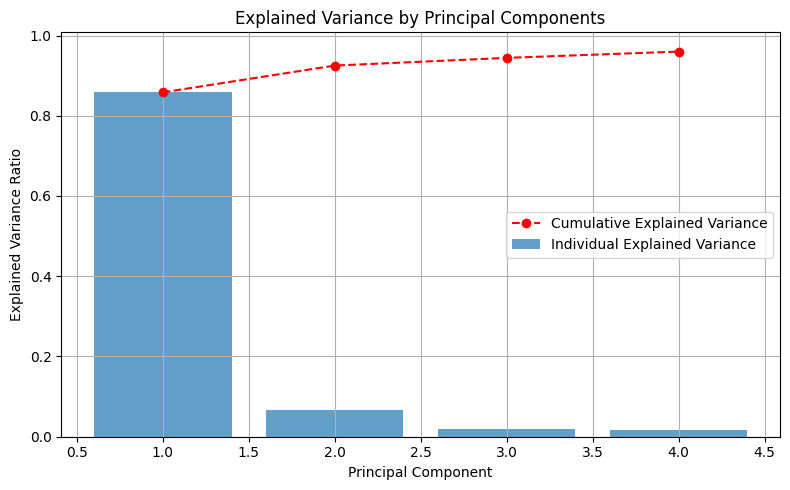

Cannot visualize 4-dimensional data directly.


c:\Users\hp\anaconda3\envs\Quant\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


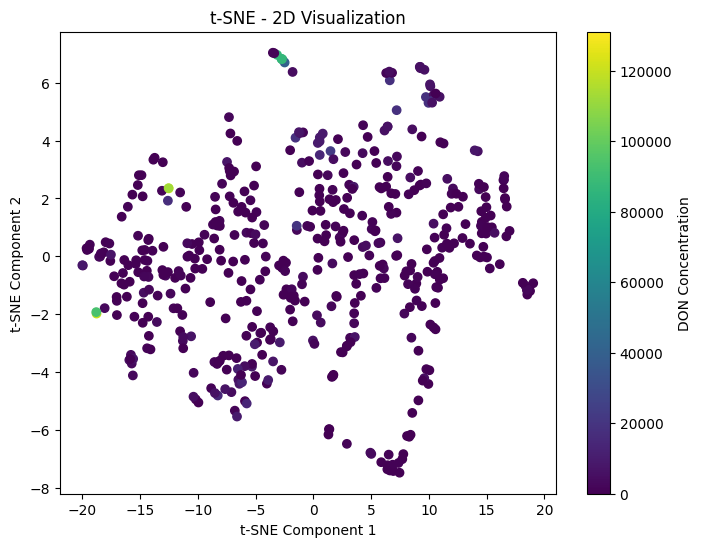

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best score (Negative MSE): -76093944.26572037
Mean Absolute Error (MAE): 2852.1417
Root Mean Squared Error (RMSE): 9250.8493
R-squared Score (R2): 0.6939


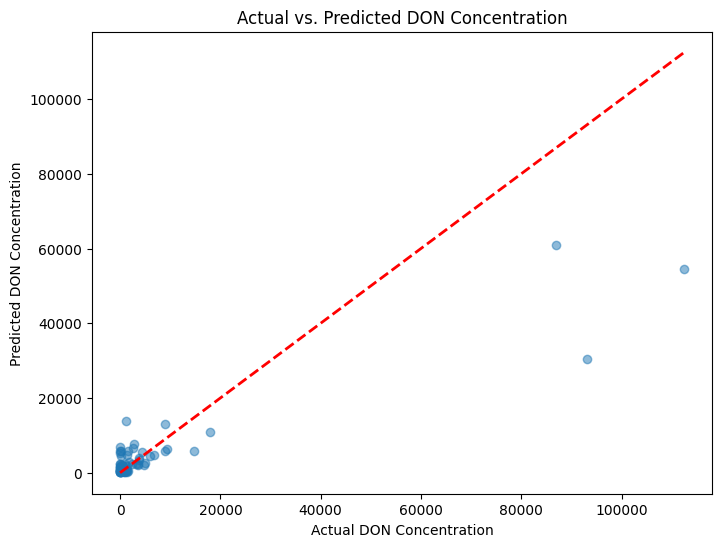


Training and Evaluation using original features (not PCA-reduced):


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor  # Import MLPRegressor
from typing import Tuple, Optional


# --- 1. Data Exploration and Preprocessing ---

def load_and_preprocess(file_path: str) -> Tuple[pd.DataFrame, pd.Series, pd.Index]:
    """Loads the dataset, handles missing values, and normalizes features.

    Args:
        file_path: Path to the CSV file.

    Returns:
        Tuple: (Processed features DataFrame, target Series, feature names)
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Dataset file not found at: {file_path}")
    except pd.errors.EmptyDataError:
        raise pd.errors.EmptyDataError("The provided CSV file is empty.")
    except Exception as e:
        raise Exception(f"An unexpected error occurred during file reading: {e}")

    # Separate features and target, handle missing values and data types robustly.
    try:
        df = df.dropna(axis=1, how='all')  # Drop columns if *all* values are NaN
        df = df.dropna(axis=0, how='any')  # Drop rows with *any* NaN values
        df = df.reset_index(drop=True)      #Reset index after row dropping.


        if 'vomitoxin_ppb' not in df.columns:
            raise ValueError("Target variable 'vomitoxin_ppb' not found in the dataset.")
        target = df['vomitoxin_ppb']
        features = df.drop(columns=['vomitoxin_ppb', 'hsi_id'])

        #Robust data type handling with explicit error handling for the most common cases
        for col in features.columns:
            try:
                features[col] = pd.to_numeric(features[col], errors='raise')
            except ValueError:
                try: #Try to remove non-numeric characters and retry
                    features[col] = features[col].astype(str).str.replace(r'[^\d\.]', '', regex=True)
                    features[col] = pd.to_numeric(features[col], errors='raise')
                except:
                    print(f"Warning: Could not convert column {col} to numeric.  Dropping this column.")
                    features = features.drop(columns=[col])


    except KeyError as e:
        raise KeyError(f"Required column not found: {e}")
    except ValueError as e:
        raise ValueError(f"Data type conversion error: {e}")

    # Feature scaling (MinMaxScaler)
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)
    features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

    return features_scaled_df, target, features.columns

def visualize_spectral_bands(features: pd.DataFrame, feature_names: pd.Index):
    """Visualizes spectral bands using line plots and heatmaps.

    Args:
        features: The feature DataFrame.
        feature_names: Names of the feature columns.
    """
    # Line plot of average reflectance
    plt.figure(figsize=(12, 6))
    plt.plot(feature_names.astype(str), features.mean(axis=0)) #Explicitly cast feature names to string.
    plt.xlabel("Wavelength Band")
    plt.ylabel("Average Reflectance")
    plt.title("Average Spectral Reflectance")
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
    plt.tight_layout()
    plt.show()

    # Heatmap of sample comparisons (first 50 samples for visibility)
    plt.figure(figsize=(12, 8))
    sns.heatmap(features.iloc[:50].T, cmap="viridis", xticklabels=50)  # Transpose for better visualization
    plt.xlabel("Sample Index (First 50)")
    plt.ylabel("Wavelength Band")
    plt.title("Spectral Reflectance Heatmap (First 50 Samples)")
    plt.tight_layout()
    plt.show()


# --- 2. Dimensionality Reduction ---

def perform_pca(features: pd.DataFrame, n_components: Optional[int] = None) -> Tuple[pd.DataFrame, PCA]:
    """Performs PCA for dimensionality reduction.

    Args:
        features: The feature DataFrame.
        n_components: Number of components to keep (optional). If None, keep enough to explain 95% variance.

    Returns:
        Tuple: (Reduced features DataFrame, PCA object)
    """
    if n_components is None:
        pca = PCA(n_components=0.95) #Keep 95% of variance.
    else:
        pca = PCA(n_components=n_components)


    features_pca = pca.fit_transform(features)
    pca_df = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])

    print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
    print(f"Cumulative Explained Variance: {np.cumsum(pca.explained_variance_ratio_)}")

    # Visualize explained variance
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, alpha=0.7, label='Individual Explained Variance')
    plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='r', label='Cumulative Explained Variance')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pca_df, pca

def perform_tsne(features: pd.DataFrame, n_components: int = 2, perplexity: int = 30, n_iter: int = 300) -> pd.DataFrame:
    """Performs t-SNE for dimensionality reduction.

    Args:
        features: The feature DataFrame.
        n_components: Number of components (usually 2 or 3).
        perplexity: Perplexity parameter.
        n_iter: Number of iterations.

    Returns:
        Reduced features DataFrame.
    """
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=n_iter, random_state=42)
    features_tsne = tsne.fit_transform(features)
    tsne_df = pd.DataFrame(features_tsne, columns=[f't-SNE{i+1}' for i in range(features_tsne.shape[1])])
    return tsne_df


def visualize_reduced_data(reduced_features: pd.DataFrame, target: pd.Series, method_name: str):
    """Visualizes the reduced data using scatter plots.

    Args:
        reduced_features: Reduced features DataFrame (2D or 3D).
        target: Target Series.
        method_name: Name of the dimensionality reduction method ('PCA' or 't-SNE').
    """
    if reduced_features.shape[1] == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features.iloc[:, 0], reduced_features.iloc[:, 1], c=target, cmap='viridis')
        plt.xlabel(f'{method_name} Component 1')
        plt.ylabel(f'{method_name} Component 2')
        plt.title(f'{method_name} - 2D Visualization')
        plt.colorbar(label='DON Concentration')
        plt.show()

    elif reduced_features.shape[1] == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reduced_features.iloc[:, 0], reduced_features.iloc[:, 1], reduced_features.iloc[:, 2], c=target, cmap='viridis')
        ax.set_xlabel(f'{method_name} Component 1')
        ax.set_ylabel(f'{method_name} Component 2')
        ax.set_zlabel(f'{method_name} Component 3')
        ax.set_title(f'{method_name} - 3D Visualization')
        fig.colorbar(scatter, label='DON Concentration')
        plt.show()
    else:
        print(f"Cannot visualize {reduced_features.shape[1]}-dimensional data directly.")

# --- 3. Model Training ---

def train_model(features: pd.DataFrame, target: pd.Series, model_type: str = 'random_forest', test_size: float = 0.2, random_state: int = 42):
    """Trains a regression model.

    Args:
        features: Feature DataFrame.
        target: Target Series.
        model_type: Type of model ('random_forest', 'xgboost', 'mlp').
        test_size: Proportion of data to use for testing.
        random_state: Random state for reproducibility.

    Returns:
        Tuple: (Trained model, training features, testing features, training target, testing target)
    """
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)

    if model_type == 'random_forest':
        model = RandomForestRegressor(random_state=random_state)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif model_type == 'xgboost':
        model = xgb.XGBRegressor(random_state=random_state, objective='reg:squarederror')
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    elif model_type == 'mlp':
        model = MLPRegressor(random_state=random_state, max_iter=500)  # Increased max_iter
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'lbfgs'],
            'alpha': [0.0001, 0.001, 0.01],
             # 'learning_rate': ['constant', 'invscaling', 'adaptive'] #Removed for lbfgs
        }
    else:
        raise ValueError("Invalid model_type. Choose 'random_forest', 'xgboost', or 'mlp'.")

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score (Negative MSE): {grid_search.best_score_}")

    return best_model, X_train, X_test, y_train, y_test


# --- 4. Model Evaluation ---

def evaluate_model(model, X_test: pd.DataFrame, y_test: pd.Series):
    """Evaluates the trained model.

    Args:
        model: Trained regression model.
        X_test: Testing features.
        y_test: Testing target.
    """
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared Score (R2): {r2:.4f}")

    # Scatter plot of actual vs. predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual DON Concentration")
    plt.ylabel("Predicted DON Concentration")
    plt.title("Actual vs. Predicted DON Concentration")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Add a diagonal line
    plt.show()



# --- Main Execution ---
if __name__ == "__main__":
    file_path = 'TASK-ML-INTERN.csv'  # Replace with the actual path to your CSV file

    # 1. Data Exploration and Preprocessing
    features_df, target_series, feature_names = load_and_preprocess(file_path)
    visualize_spectral_bands(features_df, feature_names)

    # 2. Dimensionality Reduction
    pca_features, pca_model = perform_pca(features_df) #PCA with 95% variance retained by default.
    visualize_reduced_data(pca_features, target_series, 'PCA')

    tsne_features = perform_tsne(features_df) # t-SNE, using default parameters
    visualize_reduced_data(tsne_features, target_series, 't-SNE')


    # 3. Model Training and 4. Model Evaluation (using PCA-reduced features)
    model, X_train, X_test, y_train, y_test = train_model(pca_features, target_series, model_type='random_forest') #Or 'xgboost' or 'mlp'
    evaluate_model(model, X_test, y_test)

    #Model training and evaluation using the original features (not PCA-reduced) for comparison
    print("\nTraining and Evaluation using original features (not PCA-reduced):")
    model_orig, X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_model(features_df, target_series, model_type='random_forest')
    evaluate_model(model_orig, X_test_orig, y_test_orig)